#### add SNPs as input feature for machine learning

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

In [2]:
# fetch SNPs
db_SNP = pd.read_csv('../datasets/ukb_poi40_8p.regenie',sep='\t')
snp_list = db_SNP['ID'].tolist()
snp_list

['rs35428653',
 'rs765216572',
 '19:55809016_AC_A',
 'rs1172821',
 'rs1172822',
 'rs4806659',
 'rs4806660',
 'rs34962991',
 'rs11668309',
 'rs11668344',
 'rs897798',
 'rs10425848',
 'rs11084393',
 'rs7252864',
 'rs2384686',
 'rs371808578',
 'rs148697369',
 'rs4806664',
 'rs200896099']

In [3]:
base_df_case = pd.read_csv('../datasets/final/cleaned_case.csv')
base_df_control = pd.read_csv('../datasets/final/cleaned_control.csv')
base_df_case.head()

,eid,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,qualifications,BMI,HDL-C,LDL-C,apolipoprotein B,treatment/medication code,ICD10,T2D
0,1004331,0,9,1,1,0,0,0,2,0,0,0,18.2098,-1.165660,-0.314136,0.925,0,0,0.000000
1,1005087,0,7,0,4,0,0,2,4,2,0,0,31.2883,1.115530,-0.377054,1.082,0,0,0.000000
2,1007659,0,5,1,0,0,0,3,2,3,1,1,31.8405,-0.464109,1.570590,1.113,0,0,-0.395678
3,1014838,0,7,0,1,4,0,1,0,1,0,0,24.3080,0.150831,1.169080,1.209,0,0,0.000000
4,1019851,0,9,0,5,0,0,1,2,3,0,0,25.1797,-0.638671,1.749310,0.835,1,0,0.442098


In [4]:
# merge SNPs
left_rsid = []
for rsid in snp_list:
    rsid = rsid.replace(':','_')
    try:
        genotype = pd.read_csv('../datasets/final/ped_snp_case_' + rsid + '.csv')
        A1 = genotype['A1'].tolist()
        A2 = genotype['A2'].tolist()
        base_df_case[rsid + 'A1'] = A1
        base_df_case[rsid + 'A2'] = A2
        left_rsid.append(rsid)
    except FileNotFoundError:
        pass
for rsid in snp_list:
    rsid = rsid.replace(':','_')
    try:
        genotype = pd.read_csv('../datasets/final/ped_snp_control_' + rsid + '.csv')
        A1 = genotype['A1'].tolist()
        A2 = genotype['A2'].tolist()
        base_df_control[rsid + 'A1'] = A1
        base_df_control[rsid + 'A2'] = A2
    except FileNotFoundError:
        pass
print(base_df_case.shape)
print(base_df_control.shape)
base_df_case.to_csv('../datasets/final/merged_snp_case.csv',index=False)
base_df_control.to_csv('../datasets/final/merged_snp_control.csv',index=False)

(10625, 45)
(50587, 45)


In [5]:
# remove samples without genotype
base_df_case = pd.read_csv('../datasets/final/merged_snp_case.csv')
base_df_control = pd.read_csv('../datasets/final/merged_snp_control.csv')
for rsid in left_rsid:
    base_df_case = base_df_case.drop(base_df_case[base_df_case[rsid + 'A1'].str.contains('-')].index)
    base_df_case = base_df_case.drop(base_df_case[base_df_case[rsid + 'A1'].str.contains('0')].index)
base_df_case = base_df_case.reset_index(drop=True)
print(base_df_case.shape)
for rsid in left_rsid:
    base_df_control = base_df_control.drop(base_df_control[base_df_control[rsid + 'A1'].str.contains('-')].index)
    base_df_control = base_df_control.drop(base_df_control[base_df_control[rsid + 'A1'].str.contains('0')].index)
base_df_control = base_df_control.reset_index(drop=True)
print(base_df_control.shape)
base_df_case.to_csv('../datasets/final/filtered_snp_case.csv',index=False)
base_df_control.to_csv('../datasets/final/filtered_snp_control.csv',index=False)
base_df_case.iloc[:,0:19].to_csv('../datasets/final/filtered_nosnp_case.csv',index=False)
base_df_control.iloc[:,0:19].to_csv('../datasets/final/filtered_nosnp_control.csv',index=False)

(7415, 45)
(7492, 45)


In [19]:
# encode genotype into int datatype
base_df_case = pd.read_csv('../datasets/final/filtered_snp_case.csv')
base_df_control = pd.read_csv('../datasets/final/filtered_snp_control.csv')
for rsid in left_rsid:
    A = list(set(base_df_case[rsid + 'A1'].tolist()))
    base_df_case[rsid + 'A1'].replace('^' + A[0],0,inplace=True,regex=True)
    base_df_case[rsid + 'A1'].replace('^' + A[1],1,inplace=True,regex=True)
    base_df_case[rsid + 'A2'].replace('^' + A[0],0,inplace=True,regex=True)
    base_df_case[rsid + 'A2'].replace('^' + A[1],1,inplace=True,regex=True)
for rsid in left_rsid:
    A = list(set(base_df_control[rsid + 'A1'].tolist()))
    base_df_control[rsid + 'A1'].replace('^' + A[0],0,inplace=True,regex=True)
    base_df_control[rsid + 'A1'].replace('^' + A[1],1,inplace=True,regex=True)
    base_df_control[rsid + 'A2'].replace('^' + A[0],0,inplace=True,regex=True)
    base_df_control[rsid + 'A2'].replace('^' + A[1],1,inplace=True,regex=True)
base_df_case.to_csv('../datasets/final/filtered_ensnp_case.csv',index=False)
base_df_control.to_csv('../datasets/final/filtered_ensnp_control.csv',index=False)

#### start machine learning

In [53]:
# for NO-SNP model
df_case = pd.read_csv('../datasets/final/filtered_nosnp_case.csv',index_col=0)
df_control = pd.read_csv('../datasets/final/filtered_nosnp_control.csv',index_col=0)
df_case = df_case.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

# data preparing
case_cohort = df_case.astype('float32')
control_cohort = df_control.astype('float32')

case_cohort.insert(case_cohort.shape[1], 'label', 1)
control_cohort.insert(control_cohort.shape[1], 'label', 0)
merged = pd.concat([case_cohort, control_cohort])
merged = merged.fillna(0)
merged

,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,qualifications,BMI,HDL-C,LDL-C,apolipoprotein B,treatment/medication code,ICD10,T2D,label
0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,18.209801,-1.165660,-0.314136,0.925,0.0,0.0,0.000000,1
1,0.0,5.0,1.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,1.0,31.840500,-0.464109,1.570590,1.113,0.0,0.0,-0.395678,1
2,0.0,7.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,24.308001,0.150831,1.169080,1.209,0.0,0.0,0.000000,1
3,0.0,9.0,0.0,5.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,25.179701,-0.638671,1.749310,0.835,1.0,0.0,0.442098,1
4,0.0,8.0,0.0,3.0,3.0,1.0,2.0,2.0,2.0,0.0,0.0,24.238800,0.620372,-0.228362,1.136,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,0.0,6.0,1.0,3.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,25.279200,0.701604,1.341460,1.046,0.0,0.0,-1.181410,0
7488,0.0,7.0,0.0,5.0,0.0,0.0,5.0,3.0,5.0,0.0,1.0,27.143299,0.980930,0.244087,1.033,0.0,0.0,-0.425100,0
7489,0.0,8.0,0.0,2.0,3.0,1.0,3.0,4.0,3.0,0.0,0.0,21.757401,-0.156365,-1.349850,0.806,0.0,0.0,0.000000,0
7490,0.0,7.0,0.0,3.0,2.0,1.0,1.0,5.0,1.0,0.0,1.0,22.382799,-2.221720,1.323120,0.980,0.0,0.0,0.000000,0


In [54]:
# shuffle and split dataset

#dropped = merged.drop('eid',axis=1)
shuffled = shuffle(merged)
train_data = shuffled[0:int(shuffled.shape[0]*0.9)]
test_data = shuffled[int(shuffled.shape[0]*0.9):]
print(train_data.shape[0])
print(test_data.shape[0])

# fetch values
nor_feature_train = train_data.drop('label',axis=1)
X_train = nor_feature_train.values
nor_feature_test = test_data.drop('label',axis=1)
X_test = nor_feature_test.values
Y_train = train_data['label'].values
Y_test = test_data['label'].values

13416
1491


In [11]:
# grid search
from sklearn.utils import class_weight
other_params = {'eta': 0.3, 'n_estimators': 420, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'scale_pos_weight':5,
                'seed': 33}

cv_params = {'n_estimators': np.linspace(1, 1000, 10, dtype=int)} # 400
#cv_params = {'n_estimators': np.linspace(350, 450, 11, dtype=int)} # 420
#cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 22

xgb_model = xgb.XGBClassifier(**other_params)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1,scoring='roc_auc')
gs.fit(X_train, Y_train, sample_weight=class_weight.compute_sample_weight("balanced", Y_train))
gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 1}

In [55]:
from sklearn.utils import class_weight

clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train,Y_train)
#clf_xgb.fit(X_train,Y_train)

import pickle
with open('../models/final/no-SNP-XGB.pickle', 'wb') as f:
    pickle.dump(clf_xgb, f)

confusion_matrix
 [[443 283]
 [368 397]]
accuracy:0.5633802816901409
precision:0.5838235294117647
recall:0.5189542483660131
f1-score:0.5494809688581316


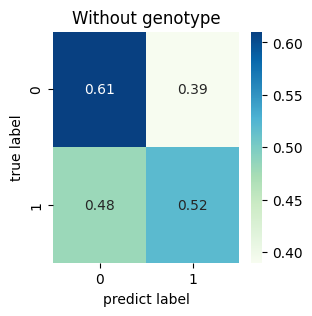

In [56]:
clf_xgb = pickle.load(open('../models/final/no-SNP-XGB.pickle', 'rb'))
y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) # (212, 2)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('confusion_matrix\n', obj1)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)

ax = plt.figure(figsize=(3, 3))
plt.title('Without genotype')
import seaborn as sns
sns.heatmap(new_obj, fmt='.2f', cmap='GnBu', annot=True)
plt.ylabel("true label")
plt.xlabel("predict label")
plt.savefig('../images/cm-noSNP.png',dpi=300, bbox_inches = 'tight')
plt.show()

AUC :  0.5972512922381146


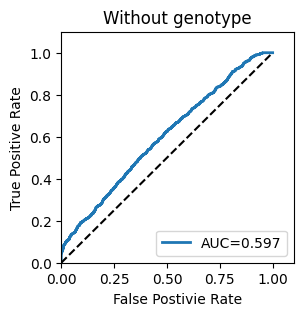

In [57]:
from sklearn.metrics import roc_curve, auc
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('Without genotype')
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb)
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('../images/auc-noSNP.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [64]:
# for SNP model
df_case = pd.read_csv('../datasets/final/filtered_ensnp_case.csv',index_col=0)
df_control = pd.read_csv('../datasets/final/filtered_ensnp_control.csv',index_col=0)
df_case = df_case.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

# data preparing
case_cohort = df_case.astype('float32')
control_cohort = df_control.astype('float32')

case_cohort.insert(case_cohort.shape[1], 'label', 1)
control_cohort.insert(control_cohort.shape[1], 'label', 0)
merged = pd.concat([case_cohort, control_cohort])
merged = merged.fillna(0)
merged

,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,...,rs10425848A2,rs11084393A1,rs11084393A2,rs2384686A1,rs2384686A2,rs371808578A1,rs371808578A2,rs4806664A1,rs4806664A2,label
0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
1,0.0,5.0,1.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
2,0.0,7.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
3,0.0,9.0,0.0,5.0,0.0,0.0,1.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4,0.0,8.0,0.0,3.0,3.0,1.0,2.0,2.0,2.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,0.0,6.0,1.0,3.0,1.0,0.0,2.0,1.0,3.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
7488,0.0,7.0,0.0,5.0,0.0,0.0,5.0,3.0,5.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0
7489,0.0,8.0,0.0,2.0,3.0,1.0,3.0,4.0,3.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
7490,0.0,7.0,0.0,3.0,2.0,1.0,1.0,5.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0


In [65]:
# shuffle and split dataset

#dropped = merged.drop('eid',axis=1)
shuffled = shuffle(merged)
train_data = shuffled[0:int(shuffled.shape[0]*0.9)]
test_data = shuffled[int(shuffled.shape[0]*0.9):]
print(train_data.shape[0])
print(test_data.shape[0])

# fetch values
nor_feature_train = train_data.drop('label',axis=1)
X_train = nor_feature_train.values
nor_feature_test = test_data.drop('label',axis=1)
X_test = nor_feature_test.values
Y_train = train_data['label'].values
Y_test = test_data['label'].values

13416
1491


In [27]:
# grid search
from sklearn.utils import class_weight
other_params = {'eta': 0.3, 'n_estimators': 420, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'scale_pos_weight':5,
                'seed': 33}

cv_params = {'n_estimators': np.linspace(1, 1000, 10, dtype=int)} # 400
#cv_params = {'n_estimators': np.linspace(350, 450, 11, dtype=int)} # 420
#cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 22

xgb_model = xgb.XGBClassifier(**other_params)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1,scoring='roc_auc')
gs.fit(X_train, Y_train)
gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 112}

In [66]:
from sklearn.utils import class_weight

clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train,Y_train)
#clf_xgb.fit(X_train,Y_train)

import pickle
with open('../models/final/SNP-XGB.pickle', 'wb') as f:
    pickle.dump(clf_xgb, f)

confusion_matrix
 [[441 332]
 [297 421]]
accuracy:0.5781354795439303
precision:0.5590969455511288
recall:0.5863509749303621
f1-score:0.5723997280761387


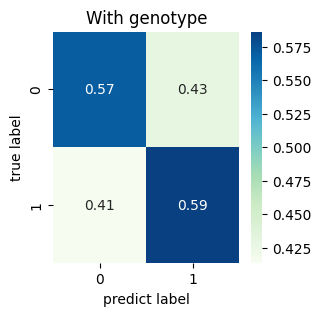

In [67]:
clf_xgb = pickle.load(open('../models/final/SNP-XGB.pickle', 'rb'))
y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) # (212, 2)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('confusion_matrix\n', obj1)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)

ax = plt.figure(figsize=(3, 3))
plt.title('With genotype')
import seaborn as sns
sns.heatmap(new_obj, fmt='.2f', cmap='GnBu', annot=True)
plt.ylabel("true label")
plt.xlabel("predict label")
plt.savefig('../images/cm-SNP.png',dpi=300, bbox_inches = 'tight')
plt.show()

AUC :  0.6020743283757992


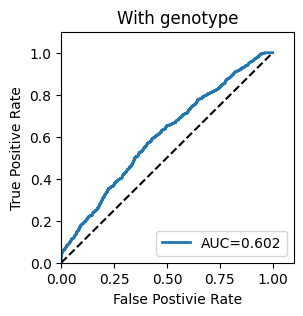

In [68]:
from sklearn.metrics import roc_curve, auc
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("AUC : ", auc_xgb)
ax = plt.subplots(figsize=(3,3))
plt.title('With genotype')
plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb)
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('../images/auc-SNP.png',dpi=300, bbox_inches = 'tight')
plt.show()

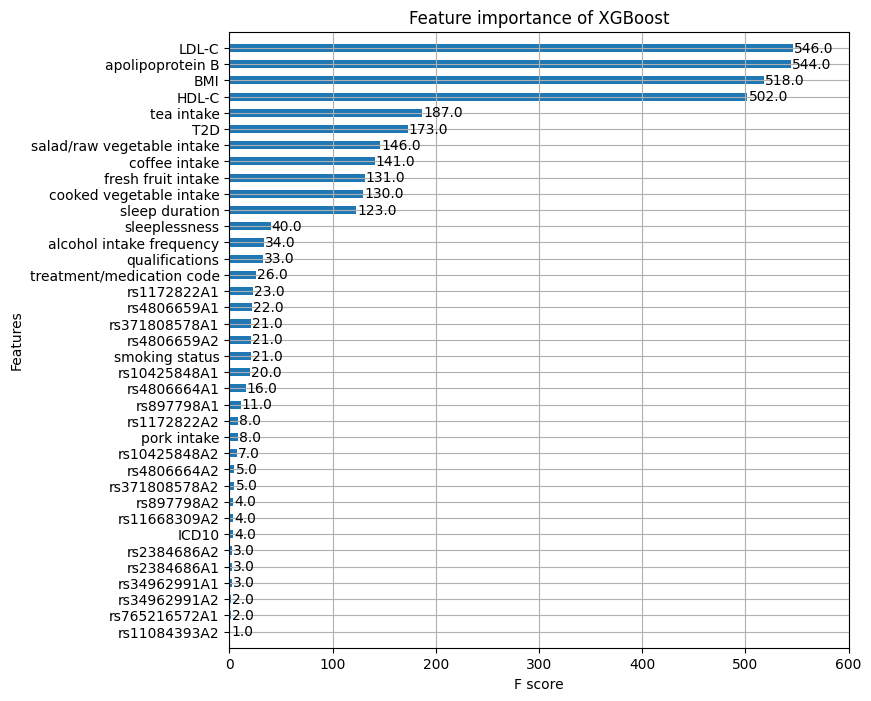

In [63]:
## feature importance
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import xgboost

# xgboost
fig,ax = plt.subplots(figsize=(8,8))
model_name='XGBoost'
feature_names = merged.drop(columns=['label']).columns.values.tolist()
clf_xgb.get_booster().feature_names = feature_names
xgboost.plot_importance(clf_xgb, ax=ax,height=0.5)
plt.title('Feature importance of '  + model_name)
plt.savefig('../images/snp_feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()